In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [19]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/aweglteo/tokyo_weather_data/main/data.csv",
    parse_dates=True,
    index_col=0,
)

In [20]:
df.head()

,cloud,wind,ave_tmp,max_tmp,min_tmp,rain
2018-05-17,9.0,3.7,24.0,28.4,21.4,0.0
2018-05-18,7.8,3.0,23.4,27.1,20.0,0.0
2018-05-19,7.5,3.9,21.5,26.3,15.3,0.0
2018-05-20,4.3,3.5,16.8,22.1,13.1,0.0
2018-05-21,10.0,2.4,20.3,27.2,13.7,0.0


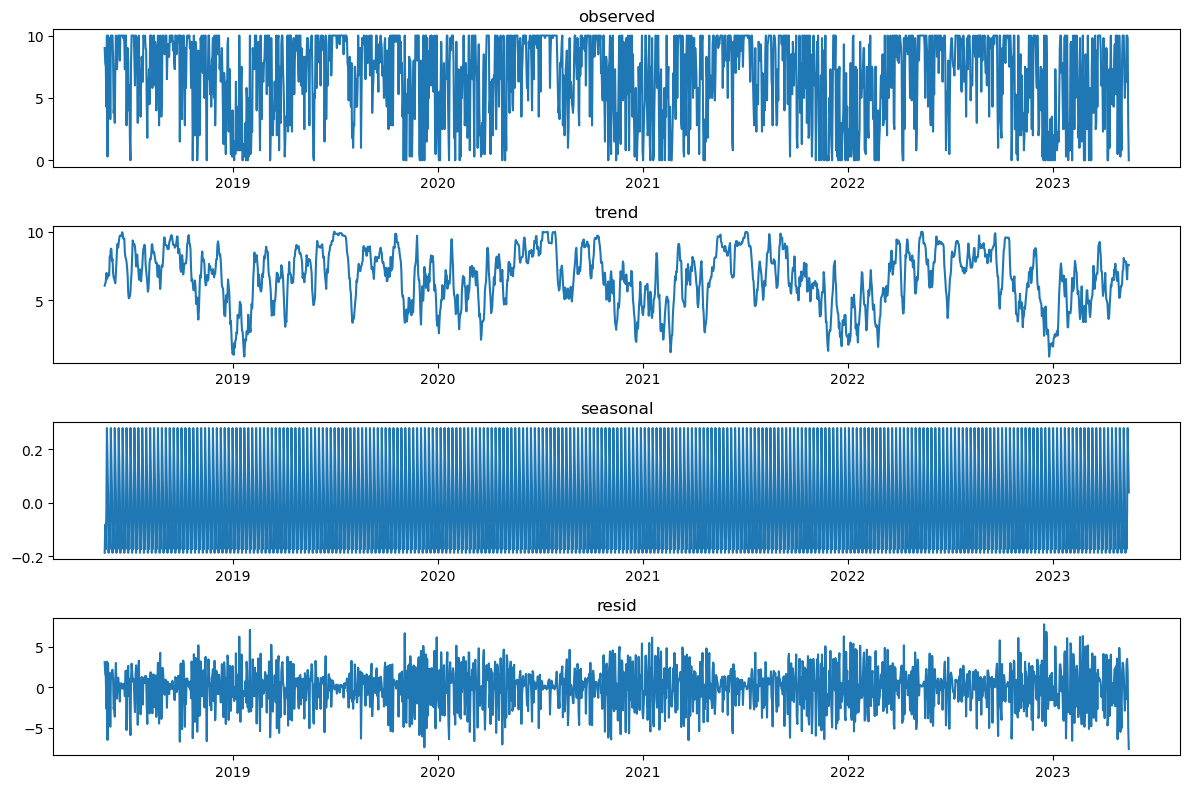

In [21]:
result = seasonal_decompose(
    df["cloud"], model="additive", period=7, extrapolate_trend="freq"
)

fig, axes = plt.subplots(4, 1, figsize=(12, 8))
for attr, ax in zip(["observed", "trend", "seasonal", "resid"], axes):
    ax.plot(getattr(result, attr))
    ax.set_title(attr)
plt.tight_layout()

In [22]:
decomp_vars = ["cloud", "ave_tmp"]

for var in decomp_vars:
    result = seasonal_decompose(
        df[var], model="additive", period=7, extrapolate_trend="freq"
    )
    df[f"{var}_trend"] = result.trend
    df[f"{var}_seasonal"] = result.seasonal
    df[f"{var}_resid"] = result.resid

In [23]:
df = df.dropna()
print("\n分解結果追加後のデータ（先頭5行）:")
print(df.head())

explanatory_cols = ["cloud", "wind", "ave_tmp", "max_tmp", "min_tmp"] + [
    f"{var}_{comp}" for var in decomp_vars for comp in ["trend", "seasonal", "resid"]
]

for col in explanatory_cols:
    df[f"{col}_lag1"] = df[col].shift(1)


分解結果追加後のデータ（先頭5行）:
            cloud  wind  ave_tmp  max_tmp  min_tmp  rain  cloud_trend  \
2018-05-17    9.0   3.7     24.0     28.4     21.4   0.0     6.063265   
2018-05-18    7.8   3.0     23.4     27.1     20.0   0.0     6.218367   
2018-05-19    7.5   3.9     21.5     26.3     15.3   0.0     6.373469   
2018-05-20    4.3   3.5     16.8     22.1     13.1   0.0     6.985714   
2018-05-21   10.0   2.4     20.3     27.2     13.7   0.0     6.557143   

            cloud_seasonal  cloud_resid  ave_tmp_trend  ave_tmp_seasonal  \
2018-05-17       -0.187064     3.123799      19.900000         -0.046763   
2018-05-18       -0.081802     1.663435      20.032653         -0.054934   
2018-05-19       -0.173037     1.299567      20.165306          0.001099   
2018-05-20       -0.033127    -2.652587      20.800000         -0.044628   
2018-05-21        0.279640     3.163218      20.328571         -0.005038   

            ave_tmp_resid  
2018-05-17       4.146763  
2018-05-18       3.422281  


In [24]:
df = df.dropna()

In [25]:
feature_cols = [f"{col}_lag1" for col in explanatory_cols]
target_col = "rain"

X = df[feature_cols]
y = df[target_col]

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [28]:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

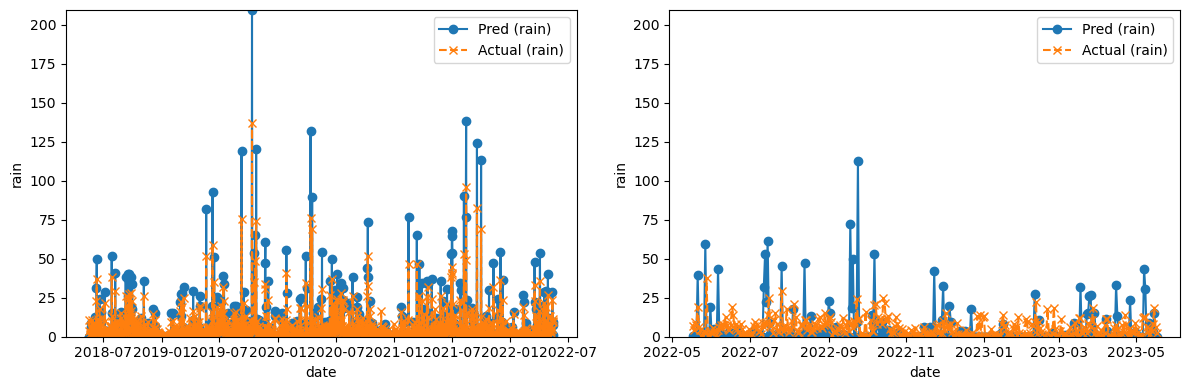

In [30]:
plot_data = [
    {
        "name": "train",
        "true": {"x": y_train.index, "y": y_train},
        "pred": {"x": y_train.index, "y": y_train_pred},
    },
    {
        "name": "test",
        "true": {"x": y_test.index, "y": y_test},
        "pred": {"x": y_test.index, "y": y_test_pred},
    },
]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, data in zip(axes, plot_data):
    ax.plot(data["true"]["x"], data["true"]["y"], label="Pred (rain)", marker="o")
    ax.plot(
        data["pred"]["x"],
        data["pred"]["y"],
        label="Actual (rain)",
        marker="x",
        linestyle="--",
    )
    ax.set_xlabel("date")
    ax.set_ylabel("rain")
    ax.set_ylim(0, y.max())
    ax.legend()
fig.tight_layout()

In [33]:
mse = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"\nTest MSE: {mse:.2f}")
print(f"Test R^2: {r2:.2f}")


Test MSE: 6.75
Test R^2: 0.00
